In [3]:
import sys
import os
sys.path.insert(1, '/cmlscratch/xic/FairRL/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# for smoothing
from scipy.ndimage.filters import gaussian_filter1d

/tmp/ipykernel_1008531/2378886784.py:9: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


## Plot several figures together

In [4]:
def collect_data_csv(exp_path, seeds, timesteps=245):
    results = np.zeros((seeds, timesteps, 3))
    actual_len = 1e10
    for seed in range(seeds):
        data_pth  = os.path.join("%s_s_%d" % (exp_path, seed) ,'eval.csv') 
        data = pd.read_csv(data_pth, sep=',', header=0)
        num_samples = data['num_timesteps'].to_numpy()
        return_arr = data['return'].to_numpy()
        bias = data['bias'].to_numpy()

        if actual_len > min(bias.size, timesteps):
            actual_len = min(bias.size, timesteps)
        
        results[seed, :actual_len, 0] = num_samples[:actual_len]
        results[seed, :actual_len, 1] = return_arr[:actual_len]
        results[seed, :actual_len, 2] = bias[:actual_len]

    results = results[:,:actual_len,:]

    return results

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)


def bootstrapping(data, num_per_group, num_of_group):
    new_data = np.array([np.mean(np.random.choice(data, num_per_group, replace=True)) for _ in range(num_of_group)])
    return new_data


def generate_confidence_interval(ys, number_per_g = 30, number_of_g = 100, low_percentile = 1, high_percentile = 99):
    means = []
    mins =[]
    maxs = []
    for i,y in enumerate(ys.T):
        y = bootstrapping(y, number_per_g, number_of_g)
        means.append(np.mean(y))
        mins.append(np.percentile(y, low_percentile))
        maxs.append(np.percentile(y, high_percentile))
    return np.array(means), np.array(mins), np.array(maxs)


def plot_ci(plt, x, y, num_runs, num_dots, linestyle='-', linewidth=3, transparency=0.2, c='red', sigma=2.0, label=None):
    assert (x.ndim==1) and (y.ndim==2)
    assert(x.size==num_dots) and (y.shape==(num_runs,num_dots))
    y_mean, y_min, y_max = generate_confidence_interval(y)
    y_mean = gaussian_filter1d(y_mean, sigma=sigma)
    y_max = gaussian_filter1d(y_max, sigma=sigma)
    y_min = gaussian_filter1d(y_min, sigma=sigma)
    plt.plot(x, y_mean, linestyle=linestyle, linewidth=linewidth, color=c, label=label)
    plt.fill_between(x, y_min, y_max, alpha=transparency, color=c)
    return


def load_and_plot(exp_dict, model_color_dict, title, reward_low=9500, reward_high=12000, file_name='output', timesteps=245, sigma_smooth=2):
    fig = plt.figure(figsize=(14, 6))
    fig.suptitle(title, fontsize=18)

    plt1 = fig.add_subplot(1, 2, 1)
    plt1.set_title("Rewards", fontsize=16)
    plt1.set_ylabel('Rewards', fontsize=16)
    plt1.set_xlabel('Training timestep', fontsize=16)
    plt1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt2 = fig.add_subplot(1, 2, 2)
    plt2.set_title("Bias", fontsize=16)
    plt2.set_ylabel('Bias', fontsize=16)
    plt2.set_xlabel('Training timestep', fontsize=16)
    plt2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    for model in exp_dict.keys():
        data = collect_data_csv(exp_dict[model][0], exp_dict[model][1], timesteps)
        indexes = data[:, :, 0]
        if model=="CPO":
            print(model)
            indexes = indexes*7
        rewards = data[:, :, 1]
        bias = data[:, :, 2]
        rewards = gaussian_filter1d(rewards, sigma=sigma_smooth)
        bias = gaussian_filter1d(bias, sigma=sigma_smooth)
        # plt1.plot(indexes[0], rewards.mean(axis=0), linewidth=2, c=model_color_dict[model], label=model)
        # plt1.fill_between(indexes[0], rewards.min(axis=0), rewards.max(axis=0), color=model_color_dict[model], alpha=0.2)
        # plt2.plot(indexes[0], bias.mean(axis=0), linewidth=2, c=model_color_dict[model], label=model)
        # plt2.fill_between(indexes[0], bias.min(axis=0), bias.max(axis=0), color=model_color_dict[model], alpha=0.2)
        num_runs = indexes.shape[0]
        num_dots = indexes.shape[1]
        plot_ci(plt1, indexes[0], rewards, num_runs=num_runs, num_dots=num_dots, linewidth=2, c=model_color_dict[model], label=model)
        plot_ci(plt2, indexes[0], np.abs(bias), num_runs=num_runs, num_dots=num_dots, linewidth=2, c=model_color_dict[model], label=model)

    # plt1.set_ylim((reward_low, reward_high))
    # plt1.set_xlim((0, 5e6))
    plt1.grid()
    #plt1.legend()

    # plt2.set_ylim((0, 0.3))
    # plt2.set_xlim((0, 5e6))
    plt2.grid()
    plt2.legend()

    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(os.path.join("figures", file_name+'.tex'))
    
    return fig

def alpha_color(alpha, color0=(1,0,0), color1=(0,0,1)):
    np_color0 = np.asarray(color0)
    np_color1 = np.asarray(color1)
    return tuple(alpha*np_color0+(1-alpha)*np_color1)

def plot_ablation(exp_path_base,b_list,title,sigma_smooth=0,lr='1e-5',save_fig=False):
    exp_dict = {}
    color_dict = {}
    for i in range(len(b_list)):
        b = b_list[i]
        exp_dict['b={}'.format(b)] = (os.path.join(exp_path_base,'b_'+str(b)+'.0_lr{}'.format(lr)),2)
        color_dict['b={}'.format(b)] = alpha_color(i /(len(b_list)-1))


    fig = load_and_plot(exp_dict, color_dict, sigma_smooth=sigma_smooth,title=title)

    if save_fig:
        fig.savefig(os.path.join(exp_path_base,'result_lr{}.png'.format(lr)))
    else:
        fig.show()
        

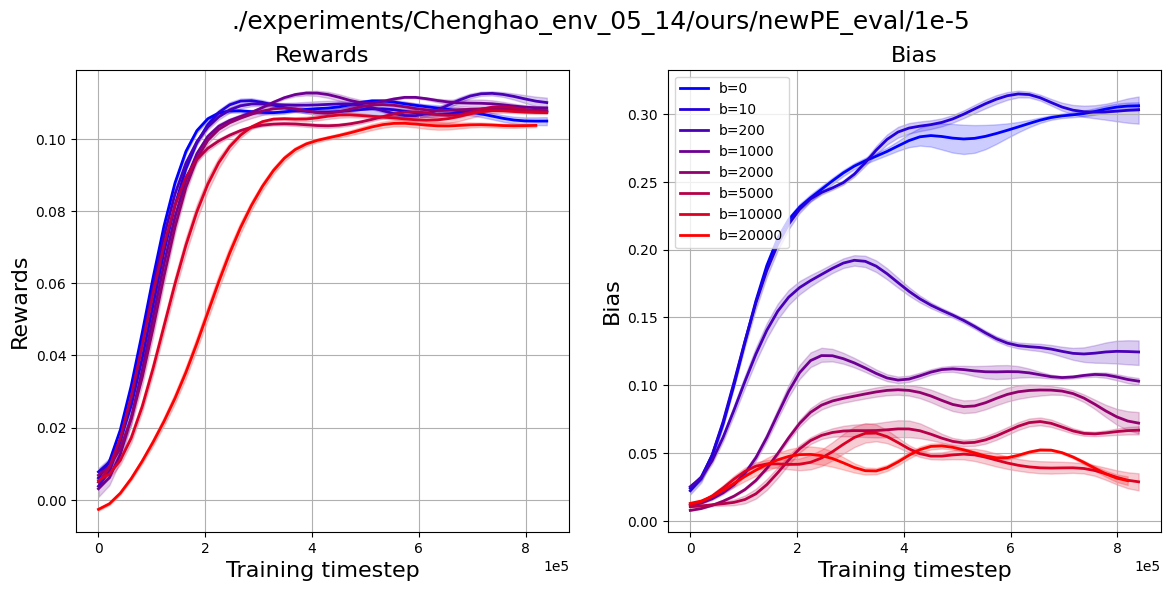

In [5]:
exp_path_base = './experiments/Chenghao_env_05_14/ours/newPE_eval/'
# exp_path_base = './experiments/original/ours/newPE_eval/'
b_list = [0,10,200,1000,2000,5000,10000,20000]
lr_str = '1e-5'

plot_ablation(exp_path_base,b_list,lr=lr_str, sigma_smooth=1,\
              title=exp_path_base+lr_str,save_fig=False)


## Previous scripts

In [11]:

def plot_return_bias(exp_path, save=True, smooth=-1):
    
    # read data
    data_pth  = os.path.join(exp_path,'eval.csv') 
    data_pth  = os.path.join(exp_path,'eval.csv') 
    data = pd.read_csv(data_pth, sep=',', header=0)
    
    # to numpy
    num_samples = data['num_timesteps'].to_numpy()

    return_arr = data['return'].to_numpy() # this is the reward averaged across timesteps and episodes, as in attention_allocation_experiment.agents.ppo.sb3.utils_fair
    benefit_max = data['benefit_max'].to_numpy()
    benefit_min = data['benefit_min'].to_numpy()
    bias = data['bias'].to_numpy()
    
    if smooth > 0:
        return_arr = gaussian_filter1d(return_arr, sigma=smooth)
        benefit_max = gaussian_filter1d(benefit_max, sigma=smooth)
        benefit_min = gaussian_filter1d(benefit_min, sigma=smooth)
        bias = gaussian_filter1d(bias, sigma=smooth)
    
    # plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (8,8), sharex=True)
    # fig, (ax1, ax3) = plt.subplots(2, figsize = (8,8), sharex=True)
    fig.suptitle('exp path: {}'.format(exp_path))
    # return
    ax1.plot(num_samples,return_arr)
    ax1.set_ylim(-0.1, 0.21)
    ax1.set_ylabel('return')
    ax1.set_title('average return / episode_len')
#     ax1.set_ylim(0.1,0.6)
    ax1.grid()
    # benefit
    ax2.plot(num_samples,benefit_max,label='benefit_max')
    ax2.plot(num_samples,benefit_min,label='benefit_min')
    ax2.legend()
    ax2.set_ylabel('benefit')
    ax2.set_title('benefit max and min')
    # bias
    ax3.plot(num_samples,bias)
    ax3.set_xlabel('Samples')
    ax3.set_ylabel('Bias')
    ax3.axhline(y=0, color='r', linestyle='-')
    ax3.set_title('Bias')
    ax3.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax3.set_ylim(-0.05,0.2)
    ax3.grid()
    if save:
        fig.savefig(os.path.join(exp_path,'result.png'))
    else:
        fig.show()

In [12]:
# seed = 0
# method_list = ['APPO','RPPO','GPPO']

# for method in method_list:
#       exp_path_base = './experiments/Chenghao_env_05_14/{}/_s_{}/'.format(method,seed)
#       plot_return_bias(exp_path_base,save=False, smooth = 2)

#       exp_path_base = './experiments/Chenghao_env_05_14/{}/_lr1e-6_s_{}/'.format(method,seed)
#       plot_return_bias(exp_path_base,save=False, smooth = 2)

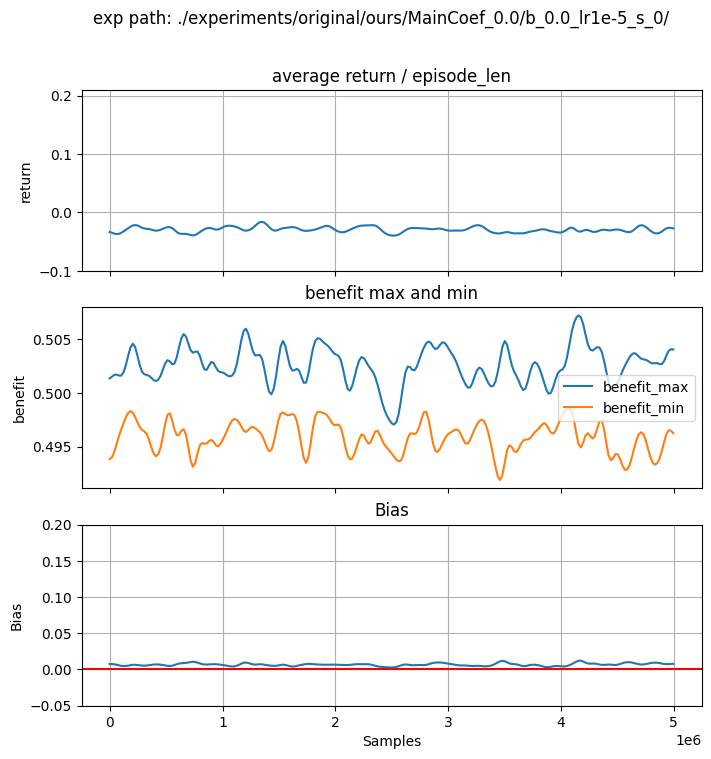

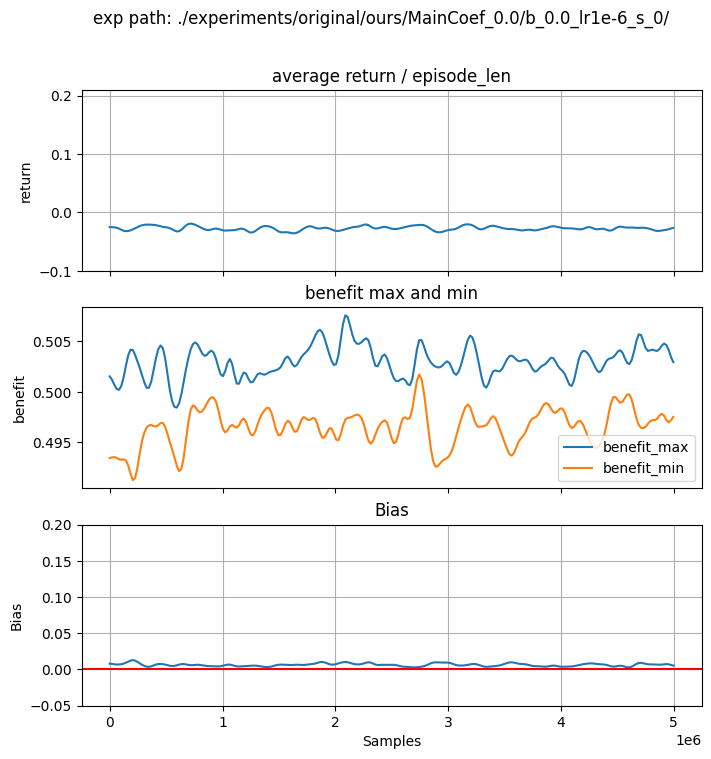

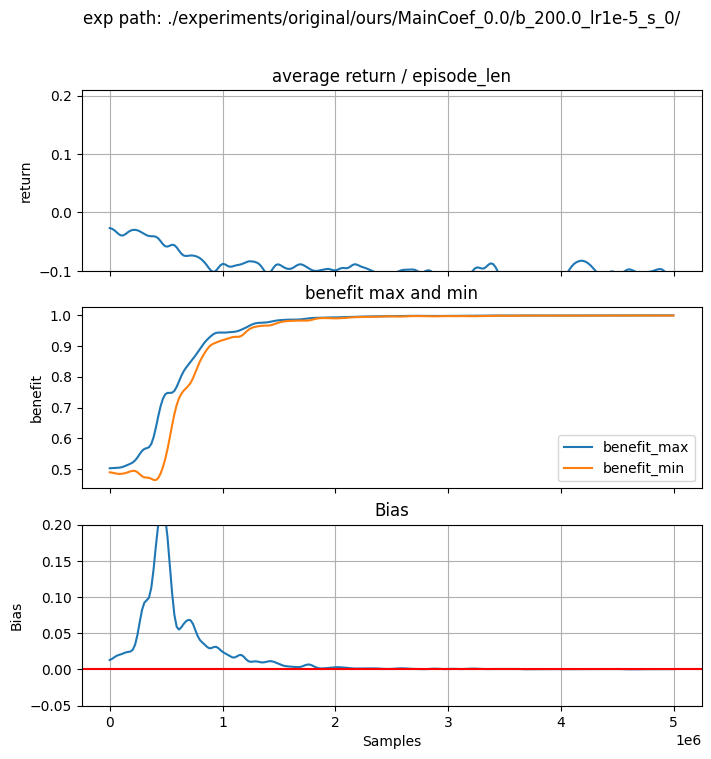

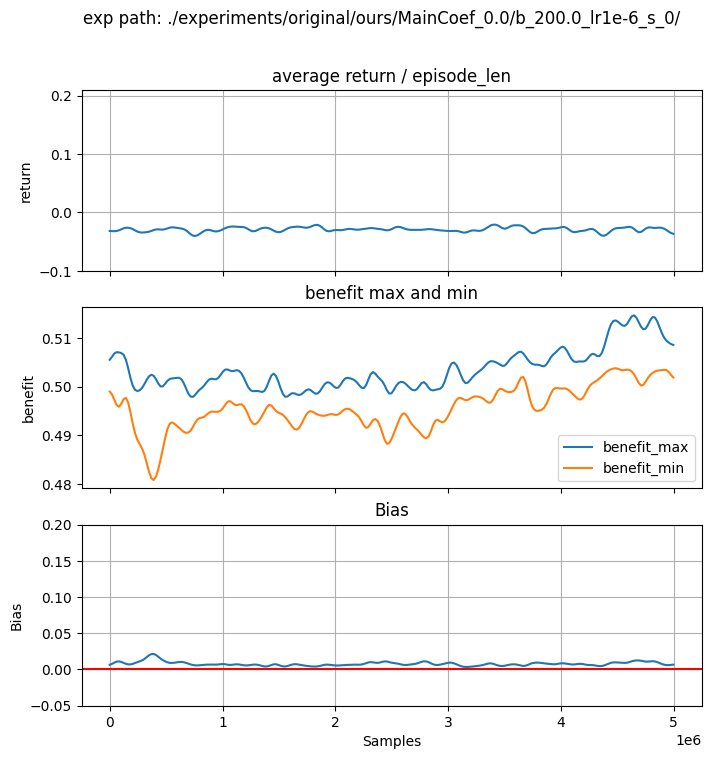

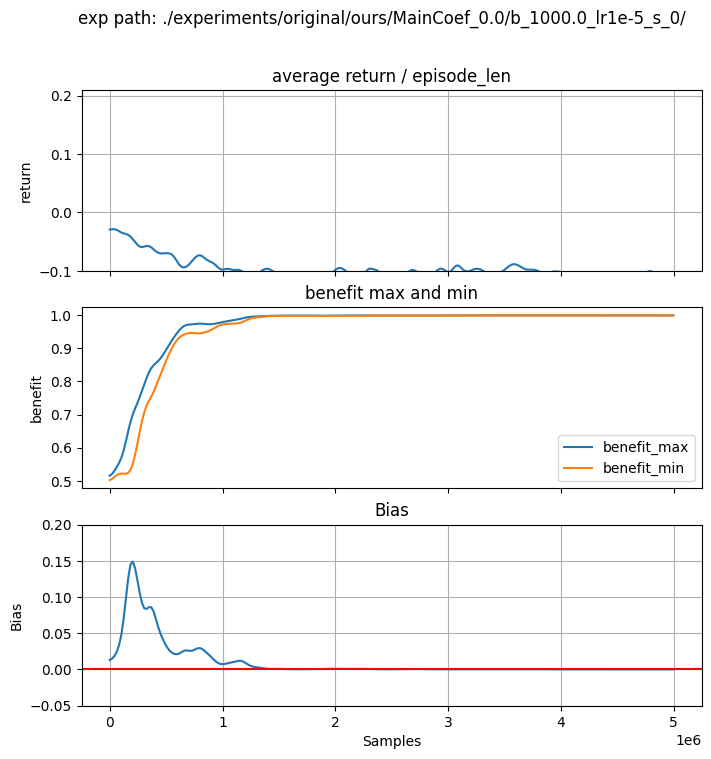

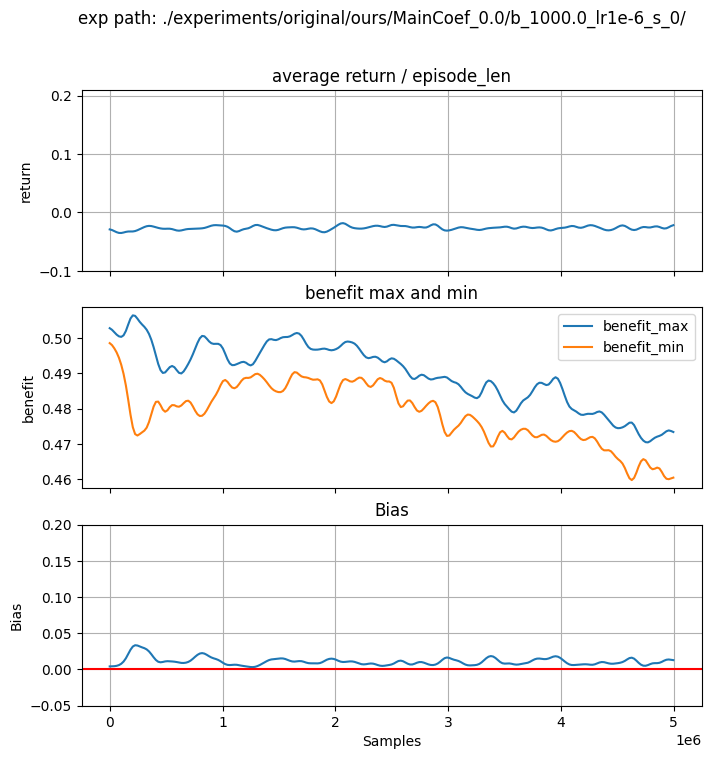

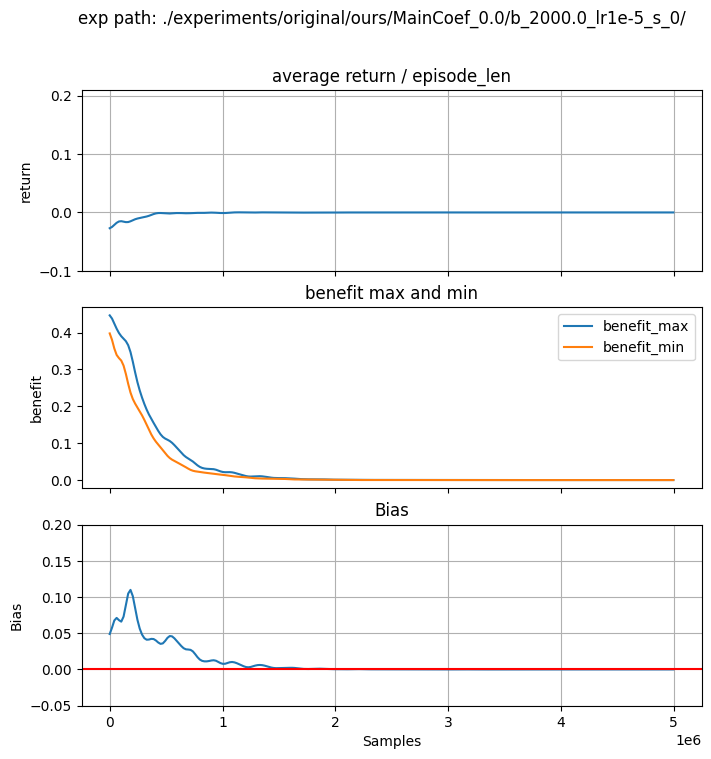

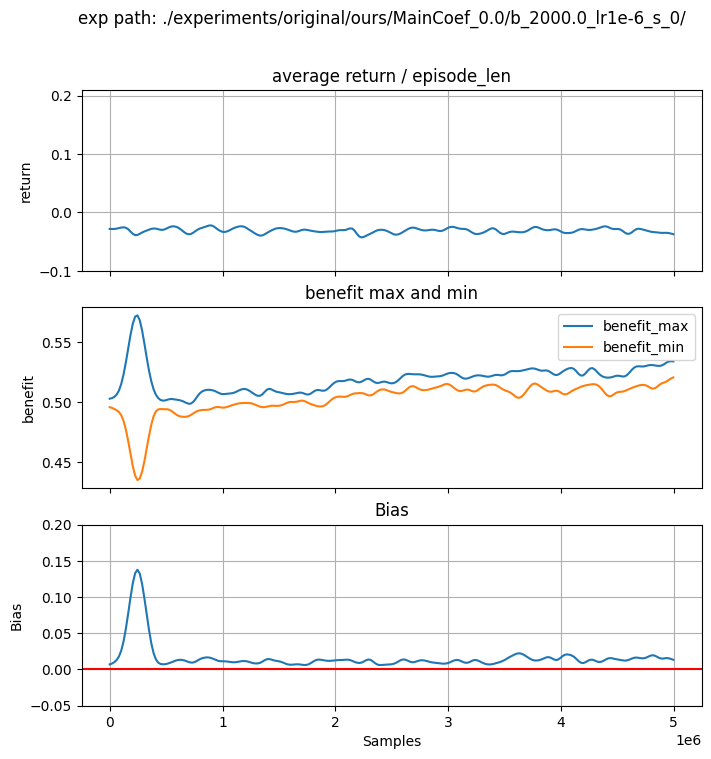

In [14]:
seed = 0
b_list = [0,200,1000,2000]
save_fig = False

for b in b_list:
      # exp_path_base = './experiments/Chenghao_env_05_14/ours/MainCoef_0.0/b_{}.0_lr1e-5_s_{}/'.format(b,seed)
      # plot_return_bias(exp_path_base,save=save_fig, smooth = 2)

      # exp_path_base = './experiments/Chenghao_env_05_14/ours/MainCoef_0.0/b_{}.0_lr1e-6_s_{}/'.format(b,seed)
      # plot_return_bias(exp_path_base,save=save_fig, smooth = 2)

      exp_path_base = './experiments/original/ours/MainCoef_0.0/b_{}.0_lr1e-5_s_{}/'.format(b,seed)
      plot_return_bias(exp_path_base,save=save_fig, smooth = 2)

      exp_path_base = './experiments/original/ours/MainCoef_0.0/b_{}.0_lr1e-6_s_{}/'.format(b,seed)
      plot_return_bias(exp_path_base,save=save_fig, smooth = 2)